<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 2: Anomaly Detection - Answers

This worksheet covers concepts relating to Anomaly Detection.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* StatsModels (https://www.statsmodels.org/stable/index.html)
* Pmdarima (http://alkaline-ml.com/pmdarima/)


In [22]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import style
from pandas.plotting import autocorrelation_plot
style.use("ggplot")
%matplotlib inline

# Part One:  Finding Anomalies in CPU Usage Data
The first part of this lab, you will be examining CPU usage data to find anomalies. 

## Step One:  Get the Data
For this example, we will be looking at CPU Utilization Data to see if we can identify periods of unusual activity.  The data can be found in several files:

* `cpu-full-a.csv`:  A full set of CPU usage data without anomalies
* `cpu-train-a.csv`:  The training set from data set A
* `cpu-test-b.csv`:  The test set from data set A
* `cpu-full-b.csv`:  A full set of CPU usage data with an anomaly
* `cpu-train-b.csv`:  The training set from data set A
* `cpu-test-b.csv`:  The test set from data set A


This dataset is from examples in *Machine Learning & Security*  by Clarence Chio and David Freeman.  https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization.

First let's take a look at the data set A.  For the first part of this lab, load the training dataset into a dataframe.  DataFrames have an option `infer_datatime_format` which, when set to `True`, will automatically infer dates. Setting this will save time and steps in data preparation. 

Once the data is loaded, call the usual series of exploratory functions and most importantly, plot the data.

In [23]:
df = pd.read_csv('../data/cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True)

In [24]:
df.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [25]:
df.sample(5)

,datetime,cpu
255,2017-01-27 22:57:00,1.70
19,2017-01-27 19:01:00,0.92
332,2017-01-28 00:14:00,0.73
181,2017-01-27 21:43:00,0.74
100,2017-01-27 20:22:00,1.93


## Step 2:  Is the Data Stationary?

Now, we are going to check to the stationarity of our data set.  Stationarity is a measurement of whether the data has seasonal trends or not.[1]

First compute the rolling mean and standard deviation for the CPU column in the data set.  This can be accomplished with the `rolling` function.[2]  Try different window sizes. 

[1]: https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
[2]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

Once you have computed the rolling mean and std, plot them on a graph with the original data.  If the lines are generally flat, we know that the data is stationary. 


In [26]:
rolling_mean = df['cpu'].rolling(15).mean()
rolling_std = df['cpu'].rolling(15).std()

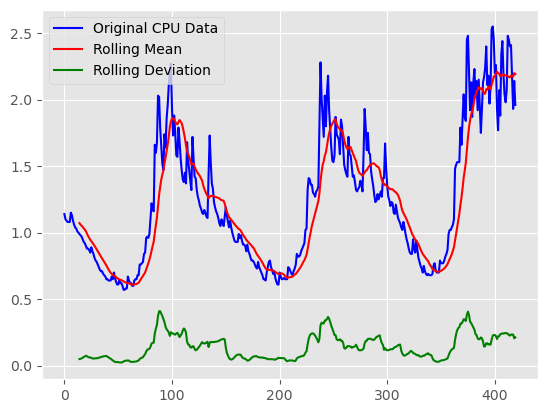

In [27]:
plt.plot(df['cpu'], color="blue",label="Original CPU Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="green", label="Rolling Deviation")
plt.legend()

plt.show()

Next we are going to run a test called the Dickey-Fuller [1] test on this data to prove whether the data is stationary or not.  Use the `adfuller` method in statsmodels to perform this computation. (https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html)  For this example, use `AIC` as the autolag parameter which means that the lag is chosen to minimize the information criterion.

[1]: https://en.wikipedia.org/wiki/Dickey–Fuller_test

In [28]:
# Your code here...
adft = adfuller(df['cpu'],autolag="AIC")

The code below will present the results in a more understandable manner.

In [29]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -1.557604              Test Statistics
1    0.504848                      p-value
2    4.000000             No. of lags used
3  415.000000  Number of observations used
4   -3.446206          critical value (1%)
5   -2.868530          critical value (5%)
6   -2.570493         critical value (10%)


### So is the Data Stationary? 
If the `p-value` is greater than 5 and the test statistics are greater than the critical values, then we know that the data is not stationary.  What do you think?


## Step Three:  Check for Autocorrelation
The next step we want to determine is how correlated the time series is with past values. This will help us tune our model and also decide whether the data can be used at all.

For this exercise, we will use the pandas `autocorrelation` methods.  

#### References
https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html
https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html

First, calculate the autocorrelation at various lag intervals. This is calculating the Pearson correlation, so 1 indiciates perfect correlation.

At what point does the correlation go below 75%?  50%?

In [30]:
# Your code here... 
for i in range(1,20):
    print(f"{i} Period Lag: {df['cpu'].autocorr(lag=i)}")

1 Period Lag: 0.9696601911106898
2 Period Lag: 0.941524611965948
3 Period Lag: 0.9209687712486443
4 Period Lag: 0.9006251581895731
5 Period Lag: 0.887671016865041
6 Period Lag: 0.8772792436448991
7 Period Lag: 0.8666828855172357
8 Period Lag: 0.8491861589374847
9 Period Lag: 0.8291953640254741
10 Period Lag: 0.8082067271439191
11 Period Lag: 0.7887008275508883
12 Period Lag: 0.7689121399874106
13 Period Lag: 0.7474582822185816
14 Period Lag: 0.7326548101962528
15 Period Lag: 0.7133703465053113
16 Period Lag: 0.6857677113949816
17 Period Lag: 0.656542582654075
18 Period Lag: 0.625754079371198
19 Period Lag: 0.5919142423393156


Now create an autocorrelation plot using the pandas autocorrelation plot method. This plot will help us visualize whether the data is correlated with itself and what the lag periods are.

(https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) 

The method is: `pd.plotting.autocorrelation_plot(<data>)`.

The horizontal lines in the plot correspond to 95% and 99% confidence bands.  The dashed line is 99% confidence band.

[]

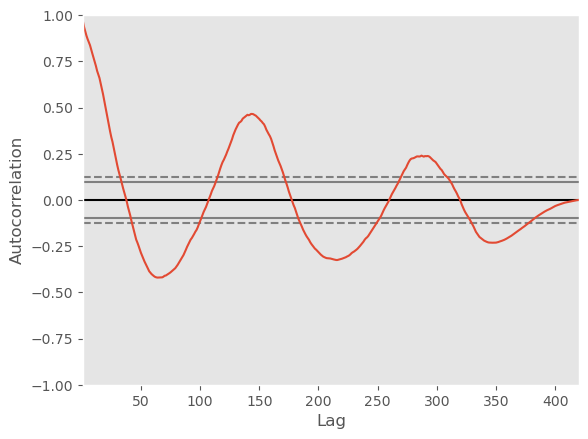

In [31]:
pd.plotting.autocorrelation_plot(df['cpu']).plot()

## Step Four:  Seasonal Decomposition
The last analytic technique we're going to use here is seasonal decomposition. Using statsmodels `seasonal_decompose` create a decompose plot and let's take a look at the data.

Use `additive` as the model type and try different values for the period. 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

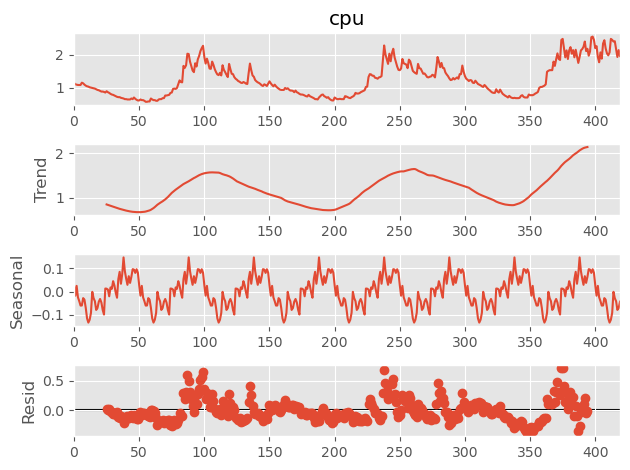

In [32]:
decompose = seasonal_decompose(df['cpu'],model='additive', period=50)
decompose.plot()
plt.show()

#### Automation

While is good to understand how this works, the module `pmdarima` actually has an automated test that can do this automatically. Try running the code below to determine whether the data is stationary or not.

```python
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df['cpu'])
```

In [33]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df['cpu'])

(0.542698180578138, True)

## Step Five:  Fit an ARIMA Model
Since we are dealing with time series data, let's train an ARIMA model and see how well this technique fits the actual data. 

ARIMA has three parameters:

* `p`:  The number of lag observations included in the model
* `d`: The number of times the raw observations are differenced
* `q`:  The size of the moving average window

We are going to use the auto_arima method in pmdarima to do our forecasting.  Let's see how it works.  First build and fit an ARIMA model setting seasonal to `True`.  


Docs:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [55]:
arima_model = auto_arima(df['cpu'], seasonal=True, error_action='ignore')

/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in r

Next, run the `summary()` method to view some summary statistics for this model.  

In [35]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  420
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 285.605
Date:                Wed, 29 Mar 2023   AIC                           -561.210
Time:                        12:51:46   BIC                           -541.020
Sample:                             0   HQIC                          -553.229
                                - 420                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1443      0.157     -0.922      0.357      -0.451       0.163
ar.L2          0.3504      0.147      2.390      0.017       0.063       0.638
ma.L1          0.0962      0.146      0.659      0.510      -0.190       0.382
ma.L2         -0.5229      0.134     -3.898      0.000      -0.786      -0.260
sigma2         0.0150      0.001     25.290      0.000       0.014       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               439.28
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using the `predict_in_sample()` method, create a plot of the original data and the predictions to see how well the model did at forecasting with known data.

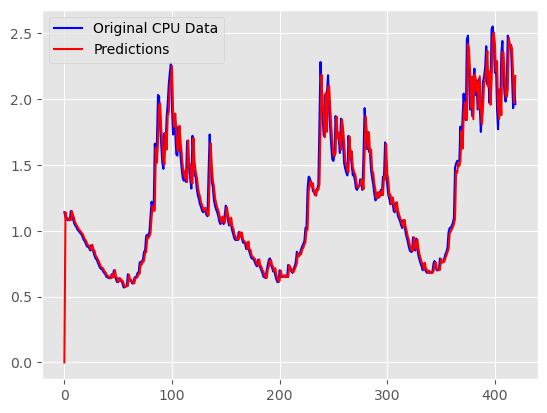

In [36]:
df['training_preds'] = arima_model.predict_in_sample()
plt.plot(df['cpu'], color="blue",label="Original CPU Data")
plt.plot(df['training_preds'], color="red", label="Predictions")
plt.legend()
plt.show()

## Step Three:  Find Anomalies in the CPU data
Using data set `B` train a new model. Once you have a trained model, the next step is to call the `.predict()` method to generate 60 predictions.  

Next, compare the predictions with the actual values in the test set, similar to how we assess the accuracy of a classifier.  We will call the difference between the actual and predicted value the anomaly score.  Calculate the anomaly score for the test data.  Finally, plot the anomaly scores, and see if you can find the time intervals with the highest anomaly score. 

In [37]:
df2_train = pd.read_csv('../data/cpu-train-b.csv', parse_dates=[0], infer_datetime_format=True)
df2_test = pd.read_csv('../data/cpu-test-b.csv', parse_dates=[0], infer_datetime_format=True)

In [38]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  600 non-null    datetime64[ns]
 1   cpu       600 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.5 KB


<AxesSubplot:>

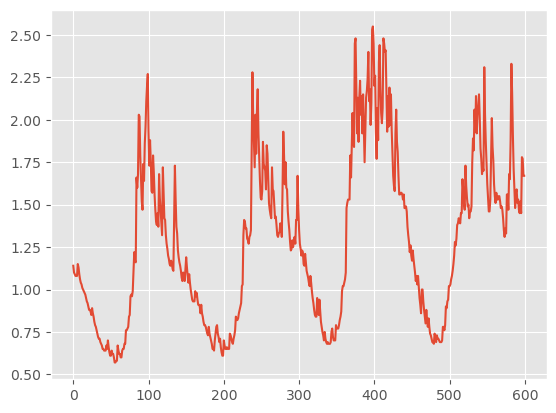

In [39]:
df2_train['cpu'].plot()

In [40]:
model2 = auto_arima(df2_train['cpu'], seasonal=True, error_action='warn')

/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/charlesgivre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [49]:
df2_test['predictions'] = model2.predict_in_sample(600)

In [50]:
df2_test['delta'] = df2_test['cpu'] - df2_test['predictions']


<AxesSubplot:>

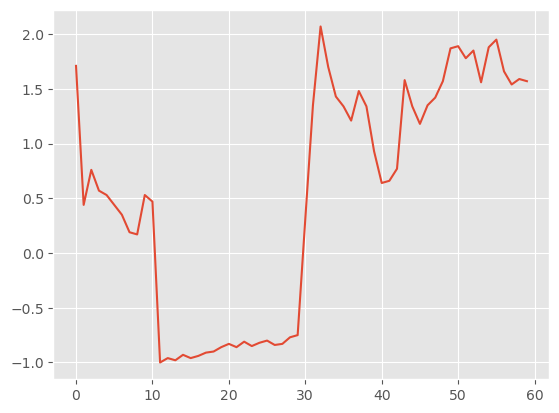

In [52]:
df2_test['delta'].plot()

<AxesSubplot:>

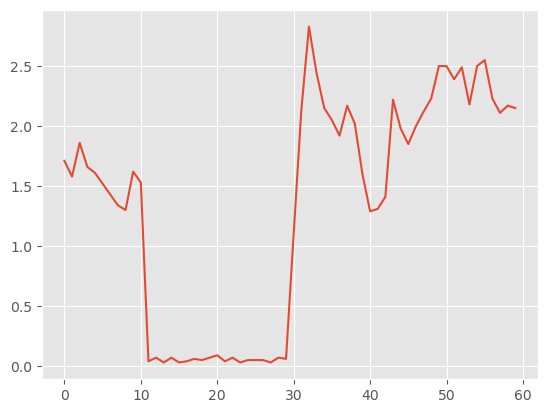

In [53]:
df2_test['cpu'].plot()

<AxesSubplot:>

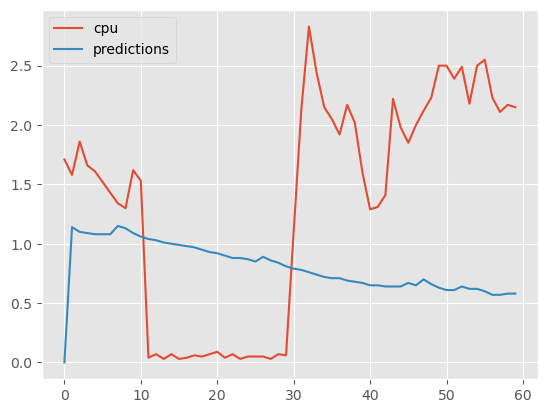

In [54]:
df2_test[['cpu','predictions']].plot()

## Conclusion:
If all went well, you should see anomalous behavior at 10 seconds into the test data.  Remembering that the forecasting's confidence goes down over time, the first anomaly should be enough to throw an alert for investigation. 